In [3]:
import warnings
warnings.filterwarnings(action='ignore') 

import datetime
import pandas as pd
import numpy as np
import csv
import folium
from folium.plugins import HeatMap 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans    ##  K-means 임포트
from sklearn.metrics import silhouette_score
import scipy as sp
from scipy.cluster.hierarchy import dendrogram, linkage
import statsmodels.formula.api as smf
from dateutil.relativedelta import relativedelta
# import setuptools.dist
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
plt.rc('font',family='D2CodingLigature Nerd Font')
# plt.rcParams['axes.unicode_minus']=False  # '- 표시

In [7]:
raw_df = pd.read_csv('../../data/covid-data.csv')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192301 entries, 0 to 192300
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    192301 non-null  object 
 1   continent                                   181123 non-null  object 
 2   location                                    192301 non-null  object 
 3   date                                        192301 non-null  object 
 4   total_cases                                 184750 non-null  float64
 5   new_cases                                   184508 non-null  float64
 6   new_cases_smoothed                          183334 non-null  float64
 7   total_deaths                                166260 non-null  float64
 8   new_deaths                                  166241 non-null  float64
 9   new_deaths_smoothed                         165078 non-null  float64
 

In [8]:
selected_columns = ['iso_code', 'location', 'date', 'total_cases', 'population']  # 원하는 항목들

df = raw_df[selected_columns]
df.head(2)

,iso_code,location,date,total_cases,population
0,AFG,Afghanistan,2020-02-24,5.0,39835428.0
1,AFG,Afghanistan,2020-02-25,5.0,39835428.0


In [ ]:
locations = df['location']
locations.unique()      # location 열의 중복제외 값 확인

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

In [12]:
#  대한민국 데이터 생성

kor_df = df[df.location == 'South Korea']
kor_df.head()

,iso_code,location,date,total_cases,population
160818,KOR,South Korea,2020-01-22,1.0,51305184.0
160819,KOR,South Korea,2020-01-23,1.0,51305184.0
160820,KOR,South Korea,2020-01-24,2.0,51305184.0
160821,KOR,South Korea,2020-01-25,2.0,51305184.0
160822,KOR,South Korea,2020-01-26,3.0,51305184.0


In [13]:
## 인덱스 변경(date를 인덱스로)
kor_date_index_df = kor_df.set_index('date')
kor_date_index_df.head()

,iso_code,location,total_cases,population
date,,,,
2020-01-22,KOR,South Korea,1.0,51305184.0
2020-01-23,KOR,South Korea,1.0,51305184.0
2020-01-24,KOR,South Korea,2.0,51305184.0
2020-01-25,KOR,South Korea,2.0,51305184.0
2020-01-26,KOR,South Korea,3.0,51305184.0


In [14]:
## 미국 데이터 생성, 인덱스를 date로 변경

usa_df = df[df.location == 'United States']
usa_date_index_df = usa_df.set_index('date')
usa_date_index_df.head()

,iso_code,location,total_cases,population
date,,,,
2020-01-22,USA,United States,1.0,332915074.0
2020-01-23,USA,United States,1.0,332915074.0
2020-01-24,USA,United States,2.0,332915074.0
2020-01-25,USA,United States,2.0,332915074.0
2020-01-26,USA,United States,5.0,332915074.0


In [15]:
# 대한민국 확진자 수 구하기
kor_total_cases = kor_date_index_df['total_cases']
kor_total_cases

date
2020-01-22           1.0
2020-01-23           1.0
2020-01-24           2.0
2020-01-25           2.0
2020-01-26           3.0
                 ...    
2022-06-03    18153851.0
2022-06-04    18163686.0
2022-06-05    18168708.0
2022-06-06    18174880.0
2022-06-07    18188200.0
Name: total_cases, Length: 868, dtype: float64

In [16]:
# 미국 확진자 수 구하기
usa_total_cases = usa_date_index_df['total_cases']
usa_total_cases

date
2020-01-22           1.0
2020-01-23           1.0
2020-01-24           2.0
2020-01-25           2.0
2020-01-26           5.0
                 ...    
2022-06-03    84724329.0
2022-06-04    84748884.0
2022-06-05    84762022.0
2022-06-06    84882287.0
2022-06-07    85003945.0
Name: total_cases, Length: 868, dtype: float64

In [17]:
## 시각화를 위한 데이터 프레임 생성
final_df = pd.DataFrame({'KOR': kor_total_cases,'USA' : usa_total_cases}, index=kor_date_index_df.index)
final_df.head(2)

,KOR,USA
date,,
2020-01-22,1.0,1.0
2020-01-23,1.0,1.0


<Axes: xlabel='date'>

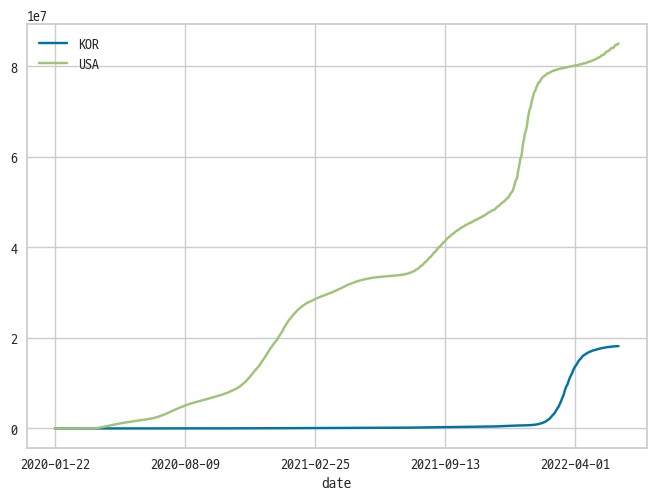

In [18]:
final_df.plot.line()

<Axes: xlabel='date'>

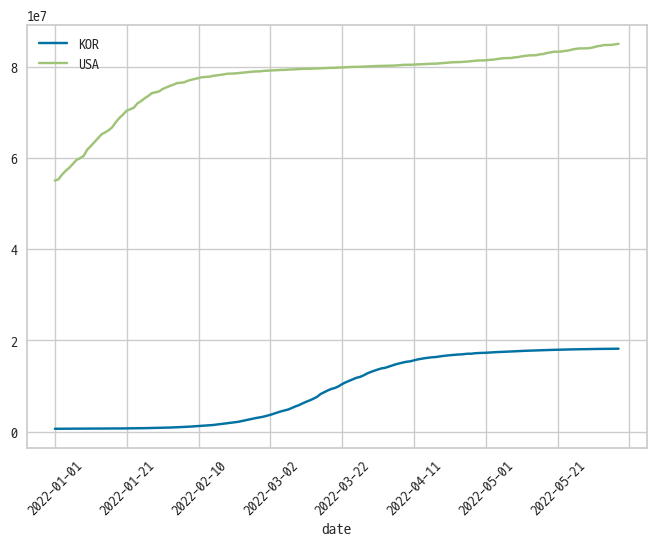

In [19]:
final_df['2022-01-01':].plot.line(rot=45)

In [20]:
# 대한민국 인구
kor_population = kor_date_index_df['population']['2020-01-22']

# 미국 인구
usa_population = usa_date_index_df['population']['2020-01-22']

print('미국 인구(', usa_population, ') ,  대한민국 인구(', kor_population, ')' )

미국 인구( 332915074.0 ) ,  대한민국 인구( 51305184.0 )


In [21]:
rate = round((usa_population / kor_population), 2)
rate

np.float64(6.49)

In [22]:
final_df = pd.DataFrame({'KOR': kor_total_cases * rate,'USA' : usa_total_cases}, index=kor_date_index_df.index)   ## 비율반영

final_df.head(2)

,KOR,USA
date,,
2020-01-22,6.49,1.0
2020-01-23,6.49,1.0


<Axes: xlabel='date'>

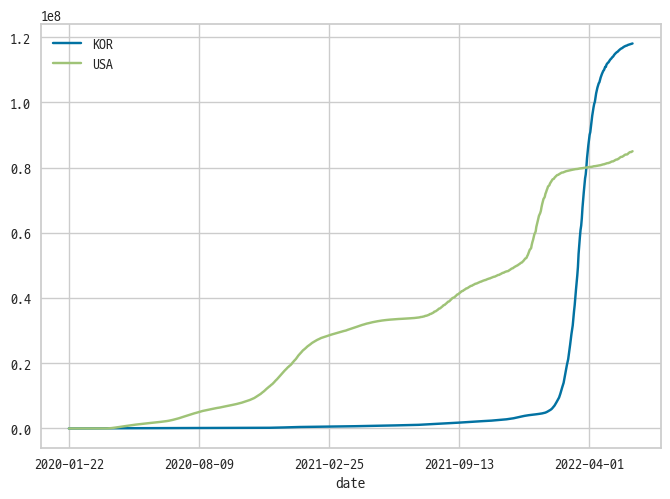

In [23]:
final_df.plot.line()

<Axes: xlabel='date'>

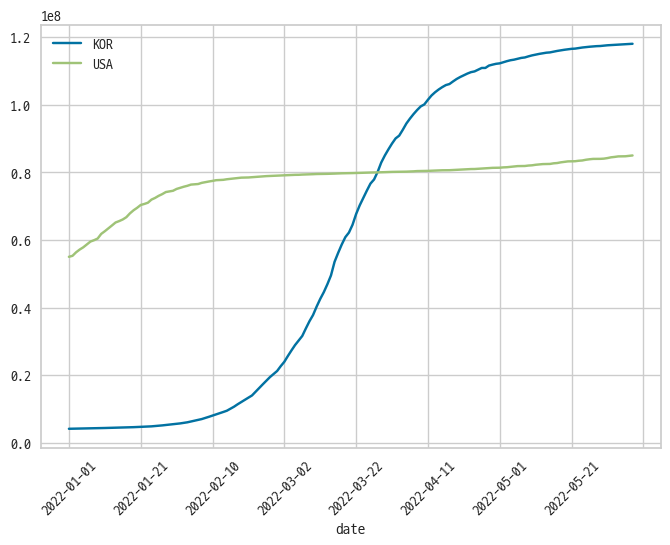

In [26]:
## 2022년 데이터만 시각화
final_df['2022-01-01':].plot.line(rot=45)

## 대륙별 신규 확진자 수

In [27]:
df = pd.read_csv('../../data/covid-data.csv')

In [ ]:
df['date'] = pd.to_datetime(df['date'])  ## 날짜 컬럼을 datetime 형식으로 변환

In [29]:
df_continent = df.dropna(subset=['continent'])  ## 대륙 정보가 있는 행만 선택 (NaN 제외)

## 대륙 + 날짜별로 그룹화 → 신규 확진자 합계 계산
df_daily = df_continent.groupby(['continent', 'date'])['new_cases'].sum().reset_index()

In [30]:
df_daily.head()

,continent,date,new_cases
0,Africa,2020-02-07,0.0
1,Africa,2020-02-08,0.0
2,Africa,2020-02-09,0.0
3,Africa,2020-02-10,0.0
4,Africa,2020-02-11,0.0


In [31]:
df_daily.tail()

,continent,date,new_cases
5243,South America,2022-06-03,47239.0
5244,South America,2022-06-04,11509.0
5245,South America,2022-06-05,56305.0
5246,South America,2022-06-06,72802.0
5247,South America,2022-06-07,86363.0


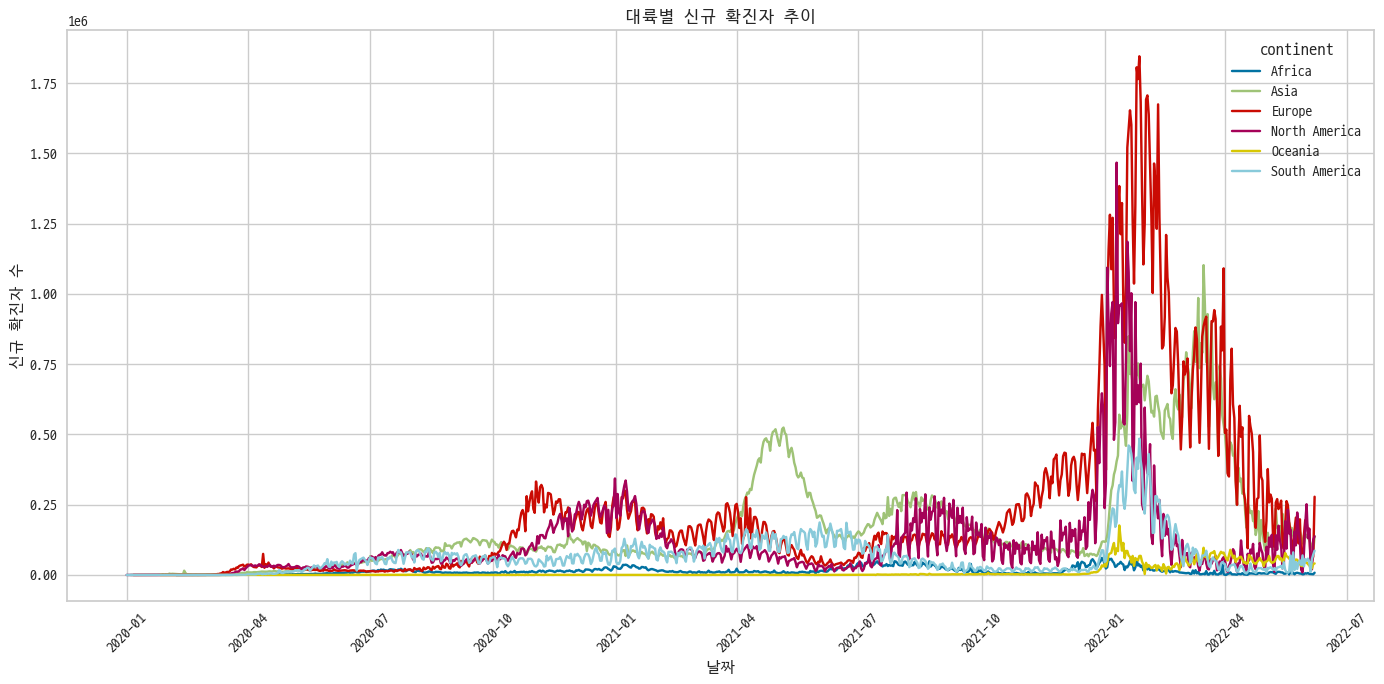

In [32]:
plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='new_cases', hue='continent', data=df_daily)
plt.title('대륙별 신규 확진자 추이')
plt.xlabel('날짜')
plt.ylabel('신규 확진자 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 전 세계적 신규확진자 추이

In [33]:
df_world = df[df['location'] == 'World']    ## 'location'이 'World'인 행만 선택
df_world_daily = df_world[['date', 'new_cases']]  ## 필요한 컬럼만 선택
df_world_daily.head()

,date,new_cases
189022,2020-01-22,0.0
189023,2020-01-23,100.0
189024,2020-01-24,287.0
189025,2020-01-25,493.0
189026,2020-01-26,683.0


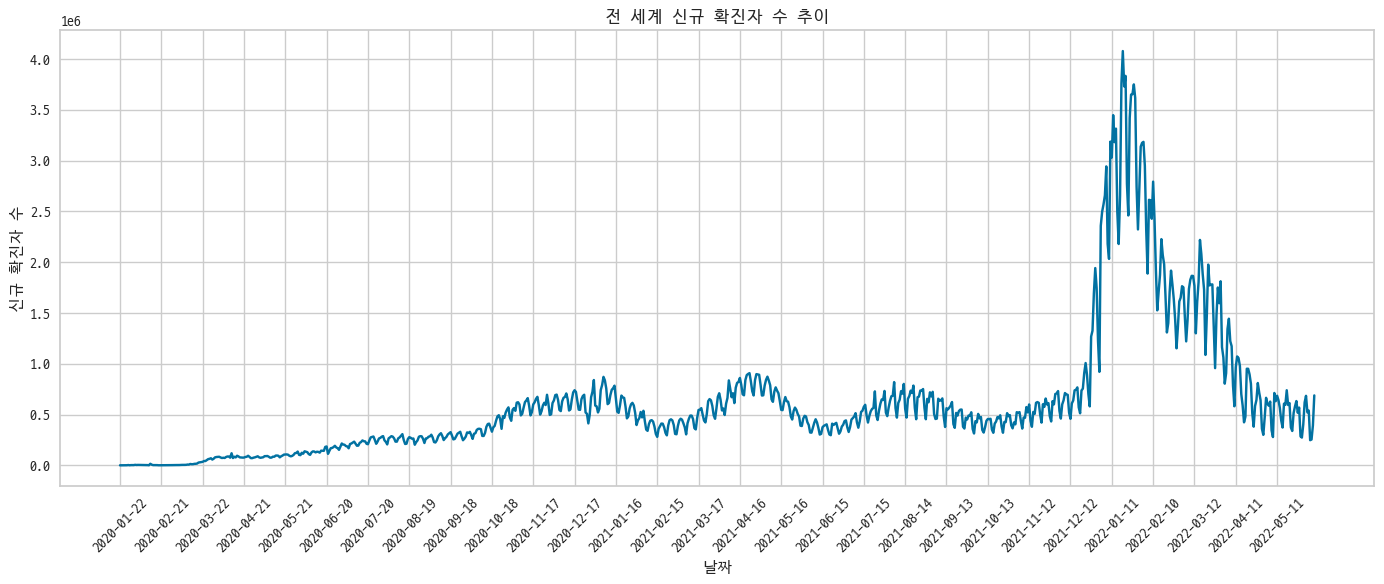

In [34]:
plt.figure(figsize=(14, 6))
sns.lineplot(x='date', y='new_cases', data=df_world_daily)
plt.title('전 세계 신규 확진자 수 추이')
plt.xlabel('날짜')
plt.ylabel('신규 확진자 수')
plt.xticks(df_world_daily['date'][::30], rotation=45)   ## [::20] : 처음부터 끝까지 20개씩 건너서
plt.tight_layout()
plt.show()